In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
# Set a seed for reproducibility
SEED = 222
np.random.seed(SEED)

# split the data into train and test sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [28]:
def logreg_fit(csv_file):
    df = pd.read_csv('../data/processed/{}'.format(csv_file))
    df.drop('Unnamed: 0', axis=1, inplace=True)
    # check if there are empty values
    assert df.isna().sum().sum()==0, 'There are missing values'
    y = df.OUTPUT_LABEL.values
    X = df.drop(['OUTPUT_LABEL'], axis=1).values
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED)
    scaler = MinMaxScaler()
    Xtrain_scaled = scaler.fit_transform(Xtrain)
    Xtest_scaled = scaler.transform(Xtest)
    start_time = time.monotonic()
    clf = LogisticRegression(C=100, solver='liblinear', random_state=SEED, class_weight='balanced', max_iter=200)
    clf.fit(Xtrain_scaled,ytrain)
    yscore = clf.predict(Xtest_scaled)
    ypred = clf.predict_proba(Xtest_scaled)[:,1]
    roc_auc = roc_auc_score(ytest, ypred)
    print("File name:{}".format(csv_file))
    print("Confusion matrix")
    print(confusion_matrix(ytest, yscore))
    print("Classification report")
    print(classification_report(ytest, yscore))
    print("AUROC {}".format(roc_auc))
    print("Time elapsed {}s".format(time.monotonic()-start_time))
    fpr, tpr, _ = roc_curve(ytest, ypred)
    fig, ax = plt.subplots(1, 2, figsize=(12,4))    
    ax[0].plot(fpr, tpr, label='Area = %0.3f' % roc_auc)
    ax[0].plot([0, 1], [0, 1],'r--')
    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver operating characteristic')
    ax[0].legend(loc="lower right")
    
    precision, recall, _ = precision_recall_curve(ytest, ypred)
    ave_prec_rec = average_precision_score(ytest, ypred)
    ax[1].plot(recall, precision, label='AP = %0.3f' % ave_prec_rec)
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall curve')
    ax[1].legend(loc="upper right")
    
    return Xtrain_scaled, Xtest_scaled, ytrain, ytest
    
    start_time = time.monotonic()

File name:feat_select_fitting_030220.csv
Confusion matrix
[[4819 2290]
 [ 153  381]]
Classification report
              precision    recall  f1-score   support

         0.0       0.97      0.68      0.80      7109
         1.0       0.14      0.71      0.24       534

    accuracy                           0.68      7643
   macro avg       0.56      0.70      0.52      7643
weighted avg       0.91      0.68      0.76      7643

AUROC 0.7459848069361884
Time elapsed 10.37796839800103s


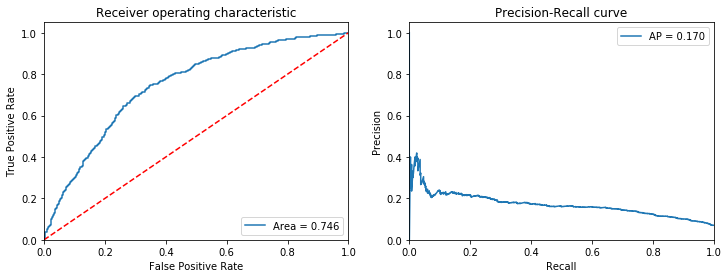

In [29]:
Xtrain_scaled, Xtest_scaled, ytrain, ytest = logreg_fit('feat_select_fitting_030220.csv')

In [31]:
def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        ap = average_precision_score(y, P.loc[:, m])
        print("%-26s: %.3f, %.3f" % (m, score, ap))
    print("Done.\n")

start_time = time.monotonic()

Cs = np.logspace(-4, 4, 9)
PL = np.zeros((ytest.shape[0], len(Cs)))
PL = pd.DataFrame(PL)


ave_train_scores=[]
test_scores=[]

logreg_models = {}
cols = list()
for i in range(len(Cs)):
    clf = LogisticRegression(C=Cs[i], random_state=SEED, solver='liblinear', class_weight='balanced')
    clf.fit(Xtrain_scaled, ytrain)
    PL.iloc[:, i] = clf.predict_proba(Xtest_scaled)[:, 1]
    cols.append(Cs[i])
    logreg_models[Cs[i]] = clf

PL.columns = cols
score_models(PL, ytest) 

Scoring models.
0.0001                    : 0.683, 0.144
0.001                     : 0.700, 0.153
0.01                      : 0.729, 0.165
0.1                       : 0.745, 0.168
1.0                       : 0.747, 0.170
10.0                      : 0.746, 0.170
100.0                     : 0.746, 0.170
1000.0                    : 0.746, 0.170
10000.0                   : 0.746, 0.170
Done.



FileNotFoundError: [Errno 2] No such file or directory: '../../reports/figures/roc_pr_no_feat_select.png'

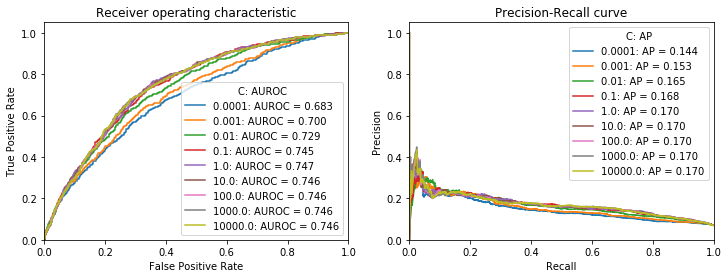

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))    


for column in PL.columns:
    roc_auc = roc_auc_score(ytest, PL[column])
    fpr, tpr, _ = roc_curve(ytest, PL[column])
    ax[0].plot(fpr, tpr, label='%s: %0.3f' % (column, roc_auc))
    
    precision, recall, _ = precision_recall_curve(ytest, PL[column])
    ave_prec_rec = average_precision_score(ytest, PL[column])
    ax[1].plot(recall, precision, label='%s: AP = %0.3f' % (column, ave_prec_rec))  
    
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('Receiver operating characteristic')
ax[0].legend(loc="lower right", title="C: AUROC")

ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall curve')
ax[1].legend(loc="upper right", title="C: AP")

plt.savefig('../reports/figures/roc_pr_no_feat_select.png')

In [32]:
PL

,0.0001,0.0010,0.0100,0.1000,1.0000,10.0000,100.0000,1000.0000,10000.0000
0,0.492090,0.443319,0.381907,0.319062,0.279687,0.271171,0.272154,0.276103,0.281731
1,0.569999,0.750291,0.880249,0.924997,0.921578,0.913825,0.919001,0.923178,0.923959
2,0.483190,0.396765,0.255211,0.192244,0.241937,0.261825,0.266327,0.268267,0.270363
3,0.554189,0.689545,0.763910,0.794493,0.841150,0.863723,0.864042,0.859751,0.858228
4,0.465530,0.361981,0.356050,0.324983,0.238229,0.220852,0.223287,0.225476,0.225542
...,...,...,...,...,...,...,...,...,...
7638,0.464802,0.327187,0.204213,0.114178,0.097235,0.102171,0.103387,0.102424,0.101973
7639,0.498408,0.464801,0.459161,0.490725,0.466950,0.436013,0.429286,0.424001,0.420545
7640,0.488861,0.418655,0.368325,0.410206,0.452106,0.473955,0.489015,0.494433,0.496007
7641,0.491629,0.416604,0.302816,0.255638,0.260082,0.262722,0.261833,0.262274,0.261842
